# Now for multiple reactions

In [2]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Create a stoichiometric matrix of 3 reactions, lets use module 1 from the paper

stoich_matrix_1 = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])

the reactions for the stoichiometric matrix above read like: (reversible)

A + D = B
B = A + E
B + D = C

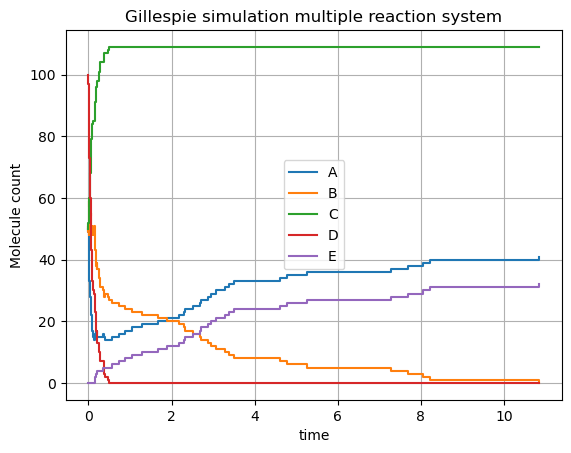

Final A: 41
Final B: 0
Final C: 109


In [26]:
# initial conditions
NA, NB, NC, ND, NE = 50, 50, 50, 100, 0                        # initial count of each species, this has input species as 100, output as 0, internals at 50 each
t, T = 0.0, 50.0                               # initial and final time
times, A_counts, B_counts, C_counts, D_counts, E_counts  = [t], [NA], [NB], [NC], [ND], [NE]
I = [1,1,1]

# algorithm:

while t < T:

    propensity_vector = [0.2*NA*ND, 0.3*NB, 0.1*NB*ND] # this reads as: probability rate for each reaction (rate * combinatorics_of_species)

    a0 = np.sum(propensity_vector)

    if a0 == 0:
        break

    r1, r2 = np.random.rand(2) # draw two random numbers - how random are they, use qiskit for quanutm randomness?

    tau = 1/a0 * np.log(1/r1)

    # Now need to select which reaction will occur using r2, prob is weighted by which is most likely to occur at the current state of the system:

    target_value = r2*a0

    cumulative = 0

    for n in range(len(propensity_vector)):

        cumulative += propensity_vector[n]

        if target_value <= cumulative:

            reaction_chosen = n

            break


    # perform updates

    t += tau

    stoich_vector = stoich_matrix_1[:,reaction_chosen] # selects the reaction we will perform

        # population change depending on stoichiometric vector

    NA += stoich_vector[0,0]; NB += stoich_vector[1,0]; NC += stoich_vector[2,0]; ND += stoich_vector[3,0]; NE += stoich_vector[4,0]


    times.append(t); A_counts.append(NA); B_counts.append(NB); C_counts.append(NC); D_counts.append(ND); E_counts.append(NE)

plt.step(times, A_counts, where="post", label="A")
plt.step(times, B_counts, where="post", label="B")
plt.step(times, C_counts, where="post", label="C")
plt.step(times, D_counts, where="post", label="D")
plt.step(times, E_counts, where="post", label="E")
plt.xlabel("time"); plt.ylabel("Molecule count")
plt.grid(True)
plt.title("Gillespie simulation multiple reaction system")
plt.legend(); plt.show()

print(r'Final A: {}'.format(A_counts[-1]))
print(r'Final B: {}'.format(B_counts[-1]))
print(r'Final C: {}'.format(C_counts[-1]))
